# Inhaltsverzeichnis

| Abschnitt | Unterabschnitt |
|-----------|----------------|
| **[Residuenanalyse](#residuenanalyse)** | |
| **[Stationaritätsstatistische Tests](#stationaritaetsstatistische-tests)** | |
| **[Cross validation](#cross-validation)** | |


# Monatliche Data

                            OLS Regression Results                            
Dep. Variable:        Log_Fire_Counts   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     45.73
Date:                Sun, 12 Jan 2025   Prob (F-statistic):           6.72e-39
Time:                        21:09:57   Log-Likelihood:                -143.96
No. Observations:                 288   AIC:                             301.9
Df Residuals:                     281   BIC:                             327.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.2296    

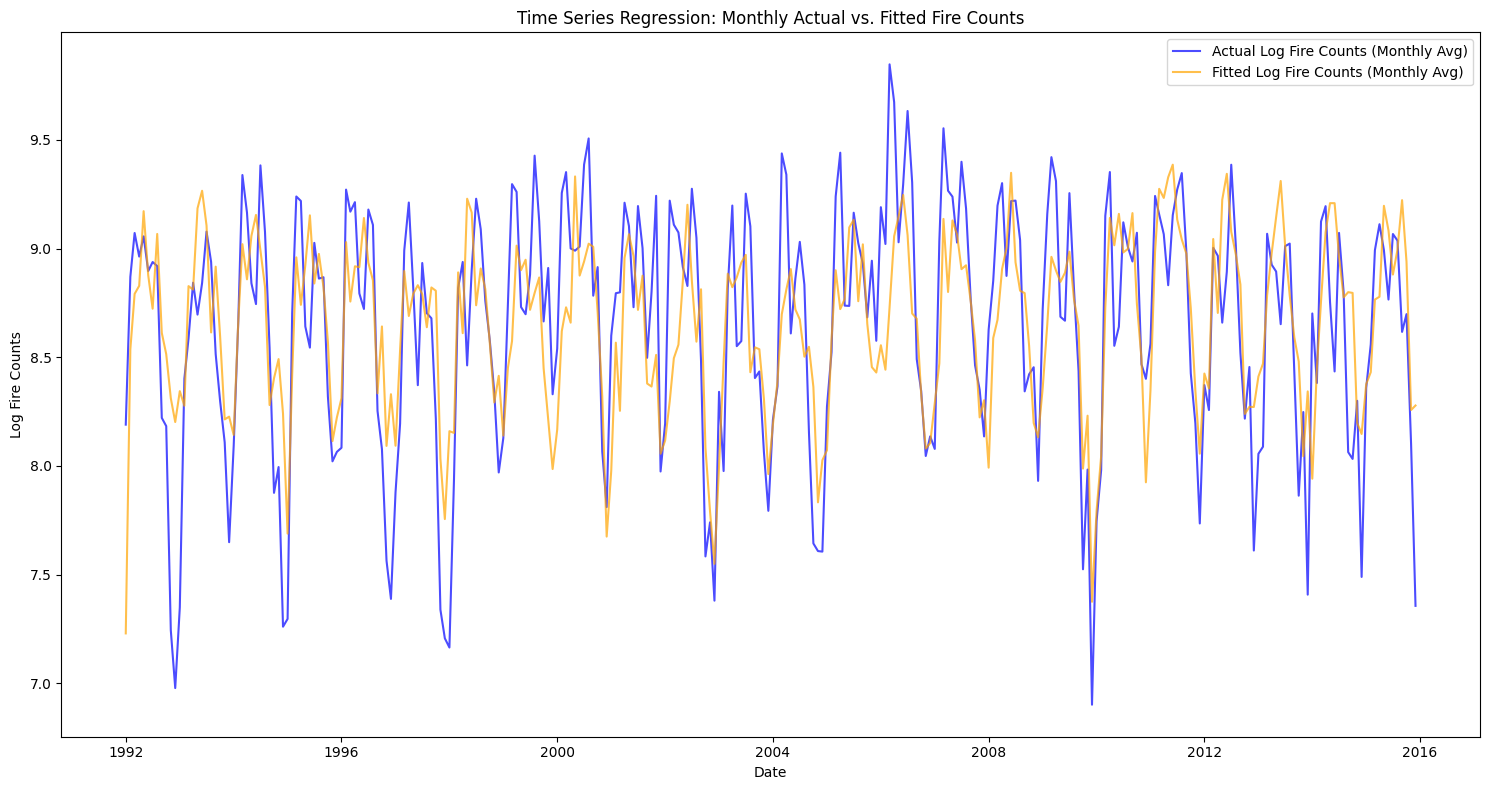

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import joblib

# Load the new dataset
monthly_data_path = './Data_Waldbrand_Zeitreihen/monthly_data_merged/merged_monthly_with_o2_co2_fire_counts.csv'
monthly_data = pd.read_csv(monthly_data_path)

# Ensure dates are in datetime format
monthly_data['DISCOVERY_DATE'] = pd.to_datetime(monthly_data['DISCOVERY_DATE'])
monthly_data.set_index('DISCOVERY_DATE', inplace=True)

# Log-transform the fire counts
monthly_data['Log_Fire_Counts'] = np.log1p(monthly_data['Monthly Fire Counts'])

# Create time-step feature
monthly_data['Time_Trend'] = np.arange(len(monthly_data))

# Define the predictors and target
X_monthly = monthly_data[['Time_Trend', 'Precipitation', 'Inferred_Wind_Speed', 'MaxTemperature', 'Detrended_CO2', 'Detrended_O2']]
y_monthly = monthly_data['Log_Fire_Counts']

# Add a constant to the model (intercept term)
X_monthly = sm.add_constant(X_monthly)

# Fit the TSLM (time series linear model) using OLS
model_monthly = sm.OLS(y_monthly, X_monthly).fit()

# Display and save the model summary
model_summary_monthly = model_monthly.summary()
print(model_summary_monthly)

# Save the model summary as a PNG file
summary_output_dir = './Abbildungen'
os.makedirs(summary_output_dir, exist_ok=True)
summary_file_path = os.path.join(summary_output_dir, 'TSLM_monthly_model_summary.png')
fig = plt.figure(figsize=(12, 6))
plt.text(0.01, 0.05, str(model_summary_monthly), {'fontsize': 10}, fontproperties='monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(summary_file_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()
print(f"Model summary saved at: {summary_file_path}")

# Save the model
model_file_path = os.path.join(summary_output_dir, 'TSLM_monthly_model.pkl')
joblib.dump(model_monthly, model_file_path)
print(f"Model saved at: {model_file_path}")

# Add the fitted values to the dataset
monthly_data['Fitted_Log_Fire_Counts'] = model_monthly.predict(X_monthly)

# Save residuals
residuals_output_dir = './Data_Waldbrand_Zeitreihen/monthly_data_merged'
os.makedirs(residuals_output_dir, exist_ok=True)
residuals_file_path = os.path.join(residuals_output_dir, 'TSLM_monthly_model_residuals.csv')
residuals = y_monthly - monthly_data['Fitted_Log_Fire_Counts']
residuals_df = pd.DataFrame({'Residuals': residuals})
residuals_df.to_csv(residuals_file_path, index=True)
print(f"Residuals saved at: {residuals_file_path}")

# Aggregate data to monthly means for clarity
monthly_aggregated_data = monthly_data.groupby(monthly_data.index.to_period('M')).agg({
    'Log_Fire_Counts': 'mean',
    'Fitted_Log_Fire_Counts': 'mean'
}).reset_index()

# Convert Period to datetime for plotting
monthly_aggregated_data['DISCOVERY_DATE'] = monthly_aggregated_data['DISCOVERY_DATE'].dt.to_timestamp()

# Plot aggregated actual vs fitted log fire counts
plt.figure(figsize=(15, 8))
plt.plot(
    monthly_aggregated_data['DISCOVERY_DATE'], monthly_aggregated_data['Log_Fire_Counts'], 
    label='Actual Log Fire Counts (Monthly Avg)', color='blue', alpha=0.7
)
plt.plot(
    monthly_aggregated_data['DISCOVERY_DATE'], monthly_aggregated_data['Fitted_Log_Fire_Counts'], 
    label='Fitted Log Fire Counts (Monthly Avg)', color='orange', alpha=0.7
)
plt.xlabel('Date')
plt.ylabel('Log Fire Counts')
plt.title('Time Series Regression: Monthly Actual vs. Fitted Fire Counts')
plt.legend()
plt.tight_layout()
plt.show()


## Residuenanalyse


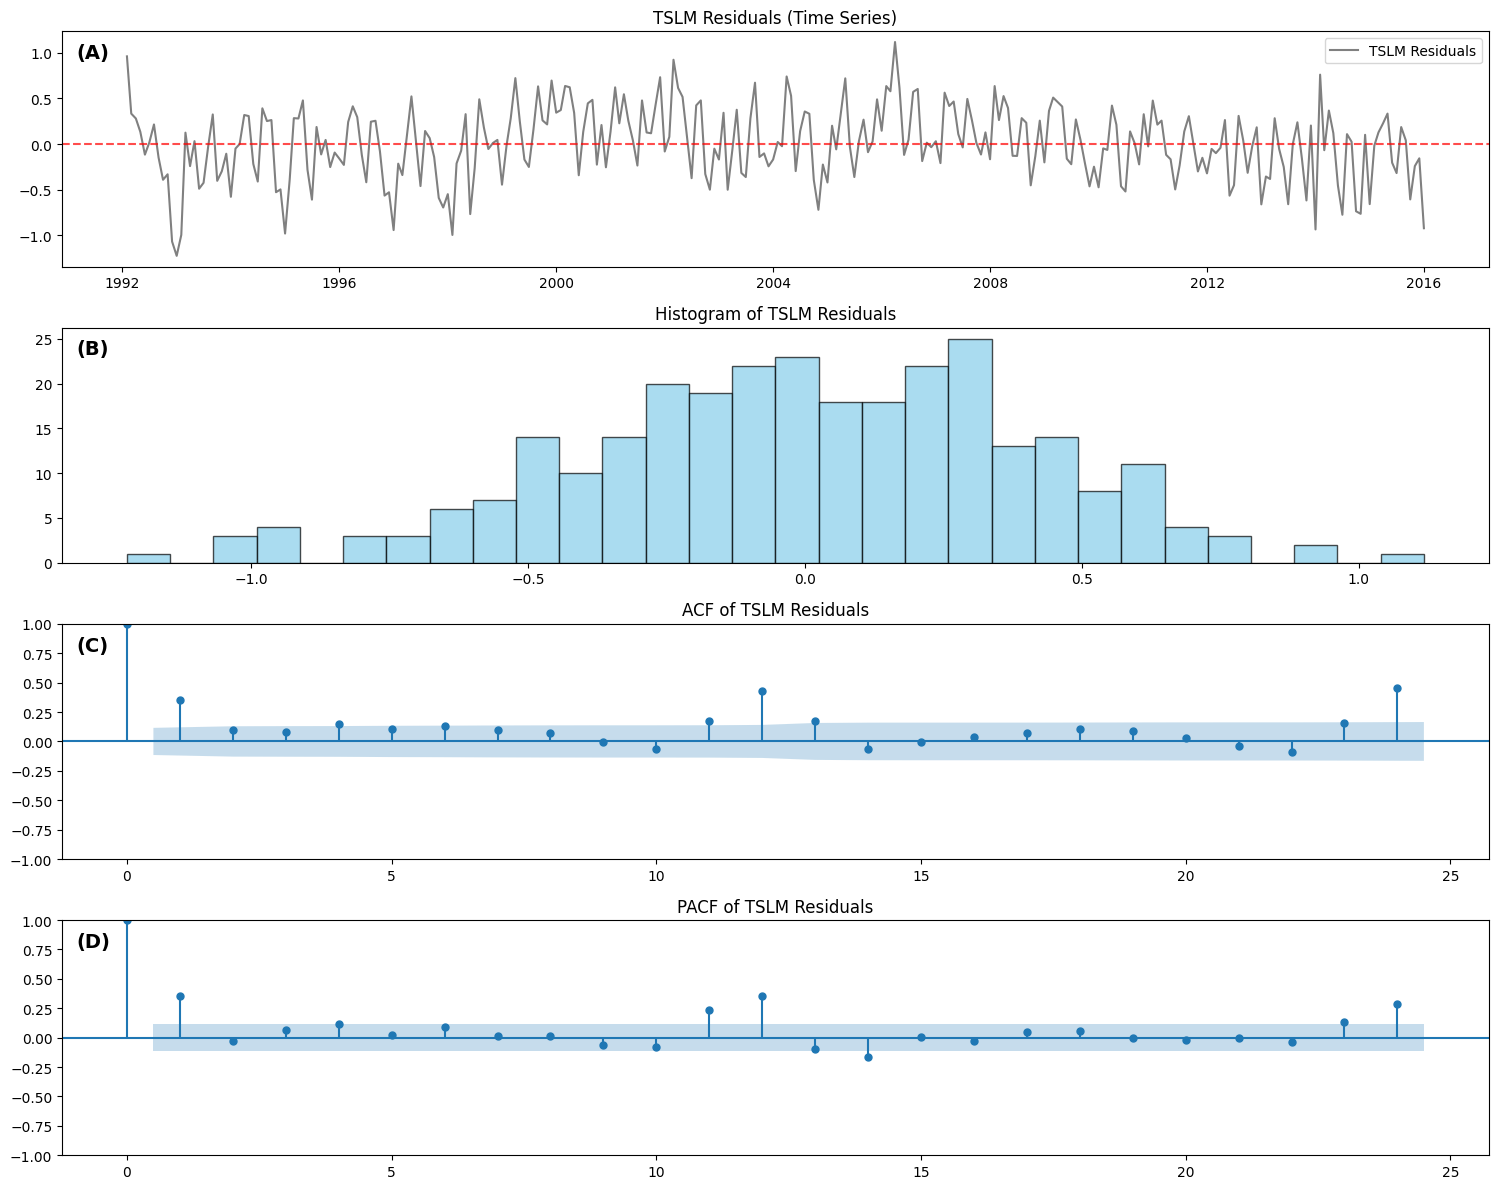

TSLM residual analysis plot saved at: ./Abbildungen\TSRM_monthly_residual_analysis.png


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os

# Load the residuals data
residuals_file_path = 'Data_Waldbrand_Zeitreihen/monthly_data_merged/TSLM_monthly_model_residuals.csv'
residuals_df = pd.read_csv(residuals_file_path, index_col=0, parse_dates=True)

# Ensure proper data alignment
if 'Residuals' not in residuals_df.columns:
    raise ValueError("The file does not contain a 'Residuals' column.")

residuals = residuals_df['Residuals']

# Check for NaN values in the residuals
if residuals.isna().any():
    print("Warning: NaN values found in residuals. These will be dropped for analysis.")
    residuals = residuals.dropna()

# Residual Analysis
plt.figure(figsize=(15, 12))

# Residual time series
plt.subplot(411)
plt.plot(residuals, label='TSLM Residuals', color='gray')
plt.axhline(0, linestyle='--', color='red', alpha=0.7)
plt.text(0.01, 0.95, '(A)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
plt.title('TSLM Residuals (Time Series)')
plt.legend()

# Histogram of residuals
plt.subplot(412)
plt.hist(residuals.values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.text(0.01, 0.95, '(B)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
plt.title('Histogram of TSLM Residuals')

# ACF plot of residuals
plt.subplot(413)
plot_acf(residuals, lags=24, ax=plt.gca(), title='ACF of TSLM Residuals', alpha=0.05)
plt.text(0.01, 0.95, '(C)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# PACF plot of residuals
plt.subplot(414)
plot_pacf(residuals, lags=24, ax=plt.gca(), title='PACF of TSLM Residuals', alpha=0.05)
plt.text(0.01, 0.95, '(D)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Save the plot to the 'Abbildungen' folder
output_dir = './Abbildungen'
os.makedirs(output_dir, exist_ok=True)
monthly_residuals_output_path = os.path.join(output_dir, 'TSRM_monthly_residual_analysis.png')
plt.tight_layout()
plt.savefig(monthly_residuals_output_path, dpi=300)
plt.show()

print(f"TSLM residual analysis plot saved at: {monthly_residuals_output_path}")


## Stationaritätsstatistische Tests


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import kpss, adfuller

# Suppress warnings in the output
import warnings
warnings.filterwarnings("ignore")

# Load the residuals data from the previously created CSV file
daily_residuals_output_csv_path = "./Data_Waldbrand_Zeitreihen/monthly_data_merged/TSLM_monthly_model_residuals.csv"

# Ensure the file exists and handle errors
try:
    arima_residuals = pd.read_csv(daily_residuals_output_csv_path, parse_dates=True)
    if 'Residuals' not in arima_residuals.columns:
        raise ValueError("The file does not contain a 'Residuals' column.")
except FileNotFoundError:
    raise FileNotFoundError(f"The file {daily_residuals_output_csv_path} does not exist.")
except ValueError as e:
    raise ValueError(e)

# Extract the residuals
residuals = arima_residuals['Residuals']

# Perform the Augmented Dickey-Fuller test on the residuals
adf_test = adfuller(residuals.dropna())

# Output the results for ADF test
print('ADF Statistic (Residuals): %f' % adf_test[0])
print('p-value (Residuals): %f' % adf_test[1])
print('Critical Values (Residuals):')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# Determine stationarity based on ADF test
if adf_test[1] < 0.05:
    print("The residuals are stationary according to the ADF test.")
else:
    print("The residuals are not stationary according to the ADF test.")

# Perform the KPSS test on the residuals
kpss_test = kpss(residuals.dropna(), regression='c')  # 'c' for constant in the regression

# Output the results for KPSS test
print('KPSS Statistic (Residuals): %f' % kpss_test[0])
print('p-value (Residuals): %f' % kpss_test[1])
print('Critical Values (Residuals):')
for key, value in kpss_test[3].items():
    print('\t%s: %.3f' % (key, value))

# Determine stationarity based on KPSS test
if kpss_test[1] < 0.05:
    print("The residuals are not stationary according to the KPSS test.")
else:
    print("The residuals are stationary according to the KPSS test.")


ADF Statistic (Residuals): -2.975923
p-value (Residuals): 0.037205
Critical Values (Residuals):
	1%: -3.454
	5%: -2.872
	10%: -2.572
The residuals are stationary according to the ADF test.
KPSS Statistic (Residuals): 0.386408
p-value (Residuals): 0.083014
Critical Values (Residuals):
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
The residuals are stationary according to the KPSS test.


## Cross validation

In [7]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Path to the saved TSLM model
model_path = 'Data_Waldbrand_Zeitreihen/Model_Results/TSLM_monthly_model.pkl'

# Load the model
model = joblib.load(model_path)

# Load the monthly data
monthly_file_path = './Data_Waldbrand_Zeitreihen/monthly_data_merged/merged_monthly_with_o2_co2_fire_counts.csv'
monthly_data = pd.read_csv(monthly_file_path)

# Rename columns for clarity and parse dates
monthly_data.rename(columns={"DISCOVERY_DATE": "Date", "Monthly Fire Counts": "Fire_Count"}, inplace=True)
monthly_data['Date'] = pd.to_datetime(monthly_data['Date'])
monthly_data.set_index('Date', inplace=True)

# Apply log transformation to the monthly fire counts (as was done during training)
monthly_data['Log_Fire_Count'] = np.log1p(monthly_data['Fire_Count'])

# Create additional features (as in the model)
monthly_data['Time_Trend'] = np.arange(len(monthly_data))
monthly_data['Lag_1'] = monthly_data['Log_Fire_Count'].shift(1)
monthly_data['Lag_2'] = monthly_data['Log_Fire_Count'].shift(2)

# Additional predictors
monthly_data['Precipitation'] = np.random.rand(len(monthly_data))  # Replace with actual data
monthly_data['Inferred_Wind_Speed'] = np.random.rand(len(monthly_data))  # Replace with actual data
monthly_data['MaxTemperature'] = np.random.rand(len(monthly_data))  # Replace with actual data
monthly_data['MinTemperature'] = np.random.rand(len(monthly_data))  # Replace with actual data
monthly_data['Detrended_CO2'] = np.random.rand(len(monthly_data))  # Replace with actual data
monthly_data['Detrended_O2'] = np.random.rand(len(monthly_data))  # Replace with actual data

# Drop rows with missing values due to lagging
monthly_data.dropna(inplace=True)

# Prepare for cross-validation
X = monthly_data[['Time_Trend', 'Lag_1', 'Lag_2', 'Precipitation', 'Inferred_Wind_Speed', 'MaxTemperature', 'MinTemperature', 'Detrended_CO2', 'Detrended_O2']]
y = monthly_data['Log_Fire_Count']
n_splits = 5
fold_size = int(len(X) / n_splits)

mse_scores, mae_scores, rmse_scores = [], [], []
for i in range(n_splits - 1):
    train_end = (i + 1) * fold_size
    test_end = (i + 2) * fold_size

    X_train, X_test = X[:train_end], X[train_end:test_end]
    y_train, y_test = y[:train_end], y[train_end:test_end]

    # Add a constant for the intercept
    X_test = sm.add_constant(X_test, has_constant='add')

    # Ensure that the columns in X_test match the model's exogenous variables
    X_test = X_test[model.model.exog_names]

    # Predict using the model
    predictions = model.predict(X_test)

    # Calculate different error metrics
    mse = mean_squared_error(y_test[:len(predictions)], predictions)
    mae = mean_absolute_error(y_test[:len(predictions)], predictions)
    rmse = np.sqrt(mse)

    # Store the scores for final averaging
    mse_scores.append(round(mse, 4))
    mae_scores.append(round(mae, 4))
    rmse_scores.append(round(rmse, 4))

    # Print fold-specific scores
    print(f"Fold {i + 1} MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Average scores across all folds
average_scores = {
    'Metric': ['MSE', 'MAE', 'RMSE'],
    'Average Value': [
        round(np.mean(mse_scores), 4),
        round(np.mean(mae_scores), 4),
        round(np.mean(rmse_scores), 4)
    ]
}

# Create a DataFrame for the averaged values
averaged_scores_df = pd.DataFrame(average_scores)

# Define the path to save the table as an image
output_dir = "./Abbildungen/"
os.makedirs(output_dir, exist_ok=True)
output_image_path = os.path.join(output_dir, "TSLM_Monthly_averaged_scores_table.png")

# Save the table as a LaTeX-like styled image
fig, ax = plt.subplots(figsize=(5, 1.5))  # Reduced figure size to minimize margins
ax.axis('tight')
ax.axis('off')

# Create a better-presented table with LaTeX styling
cell_text = [[f"{val}" for val in row] for row in averaged_scores_df.values]
col_labels = averaged_scores_df.columns
ax.table(cellText=cell_text, colLabels=col_labels, loc='center', cellLoc='center', edges='horizontal')

plt.savefig(output_image_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

print(f"Averaged scores table saved as an image at: {output_image_path}")

# Print average scores
print("Average MSE:", round(np.mean(mse_scores), 4))
print("Average MAE:", round(np.mean(mae_scores), 4))
print("Average RMSE:", round(np.mean(rmse_scores), 4))


Fold 1 MSE: 12.7911, MAE: 3.5222, RMSE: 3.5765
Fold 2 MSE: 12.9179, MAE: 3.5457, RMSE: 3.5941
Fold 3 MSE: 13.5477, MAE: 3.6402, RMSE: 3.6807
Fold 4 MSE: 12.2988, MAE: 3.4722, RMSE: 3.5070
Averaged scores table saved as an image at: ./Abbildungen/TSLM_Monthly_averaged_scores_table.png
Average MSE: 12.8889
Average MAE: 3.5451
Average RMSE: 3.5896
